In [2]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 7.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 1.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2


In [33]:
from torchtext.data.utils import get_tokenizer
from typing import Iterable, List

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

token_transform = {}
vocab_transform = {}

In [34]:
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset
import sentencepiece as spm
import os
import torch

class MyDataset(Dataset):
    def __init__(self, data_dir, src_file, trg_file=None):
        self.data_dir = data_dir
        self.src_file_path = os.path.join(self.data_dir, src_file)
        self.trg_file_path = os.path.join(self.data_dir, trg_file) if trg_file else None

        with open(self.src_file_path, "r", encoding="utf-8") as file:
            self.src_lines = file.readlines()[:50]
        self.src_lines = [line.rstrip() for line in self.src_lines]

        if self.trg_file_path:
            with open(self.trg_file_path, "r", encoding="utf-8") as file:
                self.trg_lines = file.readlines()[:50]
            self.trg_lines = [line.rstrip() for line in self.trg_lines]
            assert len(self.src_lines) == len(self.trg_lines), "Number of source and target lines must be the same."
        else:
            self.trg_lines = [None] * len(self.src_lines)
        
        self.texts = {SRC_LANGUAGE: self.src_lines, TGT_LANGUAGE: self.trg_lines}

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        if self.trg_file_path:
            src, tgt = self.src_lines[idx], self.trg_lines[idx]
            return src, tgt
        else:
            return self.src_lines[idx]

In [35]:
token_transform[SRC_LANGUAGE] = get_tokenizer(None, language='de')
token_transform[TGT_LANGUAGE] = get_tokenizer(None, language='en')
VOCAB_FILE = 'vocab.pth'

special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
vocab_transform = {}

def yielding(src: List[str], lang):
   for s in src:
      token_s = token_transform[lang](s)
      for word in token_s:
         yield word

if os.path.isfile(VOCAB_FILE):
  vocab_transform = torch.load(VOCAB_FILE)
else:
  for language in ["de", "en"]:
      your_dataset = MyDataset(data_dir="data", src_file="train.de-en.de", trg_file="train.de-en.en")
      vocab_transform[language] = build_vocab_from_iterator([yielding(your_dataset.texts[language], language)],
                                                            min_freq=1,
                                                            specials=special_symbols,
                                                            special_first=True)

  for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)
  torch.save(vocab_transform, VOCAB_FILE)


In [36]:
print(len(vocab_transform['de']), len(vocab_transform['en']))

123554 56326


In [197]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, nhead: int, dim_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dim_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        src2 = self.norm1(src)
        src = src + self.dropout(self.self_attn(src2, src2, src2, attn_mask=src_mask)[0])
        src2 = self.norm2(src)
        src = src + self.dropout(self.dropout(self.linear2(self.relu(self.linear1(src2)))))
        return src

class MyTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model: int, nhead: int, dim_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dim_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor = None, memory_mask: Tensor = None) -> Tensor:
        tgt2 = self.norm1(tgt)
        tgt = tgt + self.dropout(self.self_attn(tgt2, tgt2, tgt2, attn_mask=tgt_mask)[0])
        tgt2 = self.norm2(tgt)
        tgt = tgt + self.dropout(self.multihead_attn(tgt2, memory, memory, key_padding_mask=memory_mask)[0])
        tgt2 = self.norm3(tgt)
        tgt = tgt + self.dropout(self.linear2(self.relu(self.linear1(tgt2))))
        return tgt



In [198]:
class MyTransformerEncoder(nn.ModuleList):
    def __init__(self, encoder_layers, d_model):
        super().__init__(encoder_layers)
        self.norm = nn.LayerNorm(d_model)
        self.layers = encoder_layers

    def forward(self, src, src_mask=None):
        for layer in self.layers:
            src = layer(src, src_mask)
        src = self.norm(src)
        return src

class MyTransformerDecoder(nn.ModuleList):
    def __init__(self, decoder_layers, d_model):
        super().__init__(decoder_layers)
        self.norm = nn.LayerNorm(d_model)
        self.layers = decoder_layers

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,):
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        tgt = self.norm(tgt)
        return tgt

In [199]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 128):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        embedded_tokens = self.embedding(tokens.long())
        scaled_embeddings = embedded_tokens * math.sqrt(self.emb_size)
        return scaled_embeddings


class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layers = [MyTransformerEncoderLayer(emb_size, nhead, dim_feedforward, dropout)
                  for _ in range(num_encoder_layers)]
        self.encoder = MyTransformerEncoder(encoder_layers, emb_size)

        decoder_layers = [MyTransformerDecoderLayer(emb_size, nhead, dim_feedforward, dropout)
                        for _ in range(num_decoder_layers)]
        self.decoder = MyTransformerDecoder(decoder_layers, emb_size)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.encoder(src_emb, src_mask)
        outs = self.decoder(tgt_emb, memory, tgt_mask, src_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [200]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [201]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [202]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    
    return src_batch, tgt_batch

def test_collate_fn(batch):
    src_batch = []
    for src_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    return src_batch




In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=-100):
        """
        :param smoothing: The smoothing factor, with 0 representing no smoothing (standard cross-entropy).
        :param ignore_index: Specifies a target value that is ignored and does not contribute to the input gradient.
        """
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        """
        :param logits: Logits output from the model (before softmax).
        :param target: Target labels.
        """
        c = logits.size(1)
        log_preds = F.log_softmax(logits, dim=1)

        # Create smoothed label vector
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (c - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)

            # Apply ignore_index
            ignore = target == self.ignore_index
            true_dist[ignore] = 0

        # Mask out ignored indices from loss
        mask = torch.nonzero(ignore, as_tuple=False).squeeze()  # Find indices of ignore_index
        if mask.numel() > 0:
            log_preds = log_preds.index_fill(0, mask, 0.0)
            true_dist = true_dist.index_fill(0, mask, 0.0)

        return torch.mean(torch.sum(-true_dist * log_preds, dim=1))
    
loss_fn = LabelSmoothingLoss(smoothing=0.1, ignore_index=PAD_IDX)

In [204]:
# import torch.nn.functional as F
# class LabelSmoothingLoss(torch.nn.Module):
#     def __init__(self, classes, smoothing=0.0, ignore_index=None, dim=-1):
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.classes = classes
#         self.ignore_index = ignore_index
#         self.dim = dim

#     def forward(self, pred, target):
#         with torch.no_grad():
#             target = target.clone()
#             if self.ignore_index is not None:
#                 target[target == self.ignore_index] = 0
#             target = torch.zeros_like(pred).scatter(self.dim, target.unsqueeze(self.dim), 1.0)
#             target = target * self.confidence + (1 - target) * self.smoothing / (self.classes - 1)
#         return torch.sum(-target * F.log_softmax(pred, dim=self.dim), dim=self.dim)

# loss_fn = LabelSmoothingLoss(classes=56326, smoothing=0.1, ignore_index=PAD_IDX)

In [207]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import tensor
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt


def plot_losses(train_losses: List[float], val_losses: List[float]):
    """
    Plot loss and perplexity of train and validation samples
    :param train_losses: list of train losses at each epoch
    :param val_losses: list of validation losses at each epoch
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[0].set_ylabel("loss")

    """
    YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
    Calculate train and validation perplexities given lists of losses
    """
    train_perplexities = [math.exp(loss) for loss in train_losses]
    val_perplexities = [math.exp(loss) for loss in val_losses]

    axs[1].plot(
        range(1, len(train_perplexities) + 1), train_perplexities, label="train"
    )
    axs[1].plot(range(1, len(val_perplexities) + 1), val_perplexities, label="val")
    axs[1].set_ylabel("perplexity")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    plt.show()


def training_epoch(model, optimizer, loader, device):
    model.train()
    epoch_loss = 0.0

    for src, trg in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        src, tgt = src.to(device), trg.to(device)
        tgt_input = tgt[:-1, :]

        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask)
        # print('output', output.shape)
        # print('tgt', tgt_input.shape)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)).mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

@torch.no_grad()
def validation_epoch(model, loader, device):
    model.eval()
    epoch_loss = 0.0

    for src, trg in tqdm(loader, desc="Training"):
        src, tgt = src.to(device), trg.to(device)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)).mean()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)



def train(model, optimizer, train_loader, val_loader, num_epochs, device, pad_id):
    train_losses, val_losses = [], []

    # criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id)

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(model, optimizer, train_loader, device)
        val_loss = validation_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        plot_losses(train_losses, val_losses)

    print(f"Training complete. Best validation loss: {min(val_losses)}")

    return min(val_losses)

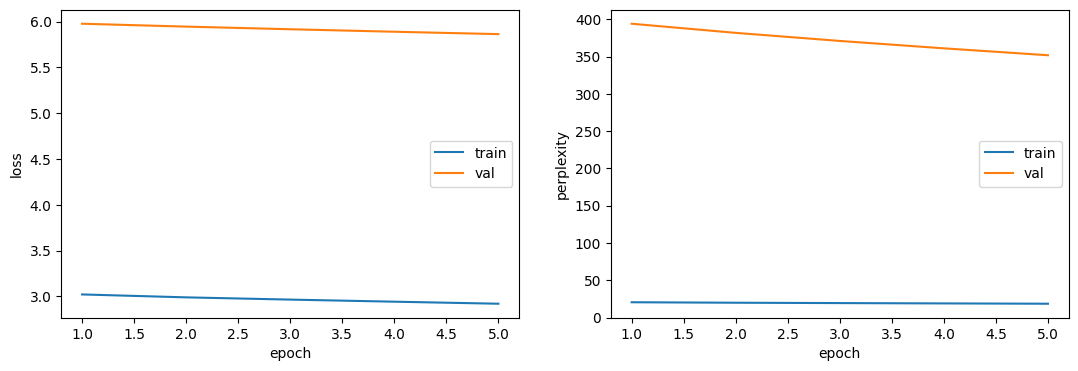

Training complete. Best validation loss: 5.863245010375977


5.863245010375977

In [208]:
NUM_EPOCHS = 5

train_dataset = MyDataset(data_dir="data", src_file="train.de-en.de", trg_file="train.de-en.en")
val_dataset = MyDataset(data_dir="data", src_file="val.de-en.de", trg_file="val.de-en.en")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

train(transformer, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE, PAD_IDX)



In [209]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(DEVICE)
        # print(ys.size(), memory.size(), tgt_mask.size())
        out = model.decode(ys, memory, tgt_mask)
        # out = out.transpose(0, 1)
        prob = model.generator(out[:, -1, :])
        # print(prob.shape)
        _, next_word = torch.max(prob, dim=1)
        # print(next_word)
        _, next_word = torch.max(next_word, dim=0)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, loader):
    model.eval()
    translated = []
    for src in tqdm(loader, "Prediction"):
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
        translation = " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")
        translated.append(translation)
        print(translation)
    return translated

In [210]:
test_dataset = MyDataset('data', 'test1.de-en.de')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_collate_fn)
translations = translate(transformer, test_loader)

Prediction:   0%|          | 0/50 [00:00<?, ?it/s]

 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 <unk> <u